In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

    
# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *
from functions.impresion import *

In [6]:
flujos_loc = pd.read_csv('tablas/dd_localidades.csv')
print(flujos_loc.shape[0])
flujos_loc.head(3)

377610


,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635.0,583715
1,10202521,1020,2521,1304729,12200,90.0,612802
2,10202522,1020,2522,1304729,2659,17.0,617076


In [7]:
locs = cargar_datos_geo()[2][['CODLOC', 'geometry']]
locs.head(3)

/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,CODLOC,geometry
0,2220,POINT (549273.219 6633915.063)
1,2521,POINT (442454.671 6652273.541)
2,2522,POINT (457921.001 6633361.660)


In [8]:
locs_cod = list(locs.CODLOC)
len(locs_cod) ** 2 - len(locs_cod)

377610

In [9]:
# pega geometrías
dd = flujos_loc.merge(locs, left_on='cod_ori', right_on='CODLOC')
dd = dd.merge(locs, left_on='cod_des', right_on='CODLOC')
dd.drop(['CODLOC_x', 'CODLOC_y'], axis=1, inplace=True)
dd.rename({'geometry_x':'geom_ori', 'geometry_y':'geom_des'}, axis=1, inplace=True)

dd.head()

# exporta CSV con geometrías puntuales para mapa de flujos
#dd.to_csv('capas/loc_lines.csv', index=False)

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,geom_ori,geom_des
0,10202220,1020,2220,1304729,40657,635.0,583715,POINT (573082.248 6145008.434),POINT (549273.219 6633915.063)
1,25212220,2521,2220,12200,40657,NaN,137927,POINT (442454.671 6652273.541),POINT (549273.219 6633915.063)
2,25222220,2522,2220,2659,40657,NaN,111408,POINT (457921.001 6633361.660),POINT (549273.219 6633915.063)
3,26212220,2621,2220,2531,40657,NaN,106867,POINT (468458.270 6601361.867),POINT (549273.219 6633915.063)
4,27212220,2721,2220,380,40657,NaN,58392,POINT (502880.928 6648162.053),POINT (549273.219 6633915.063)


In [10]:
print(flujos_loc.shape)
flujos_loc.head()

(377610, 7)


,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635.0,583715
1,10202521,1020,2521,1304729,12200,90.0,612802
2,10202522,1020,2522,1304729,2659,17.0,617076
3,10202621,1020,2621,1304729,2531,9.0,595785
4,10202721,1020,2721,1304729,380,NaN,628213


In [11]:
flujos_loc.loc[flujos_loc.personas_mig.isna(), 'personas_mig'] = 0.001
flujos_loc.head()

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635.000,583715
1,10202521,1020,2521,1304729,12200,90.000,612802
2,10202522,1020,2522,1304729,2659,17.000,617076
3,10202621,1020,2621,1304729,2531,9.000,595785
4,10202721,1020,2721,1304729,380,0.001,628213


In [12]:
flujos_loc['log_dist'] = np.log(flujos_loc.distancia_m)
flujos_loc.head()

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,log_dist
0,10202220,1020,2220,1304729,40657,635.000,583715,13.277168
1,10202521,1020,2521,1304729,12200,90.000,612802,13.325797
2,10202522,1020,2522,1304729,2659,17.000,617076,13.332747
3,10202621,1020,2621,1304729,2531,9.000,595785,13.297635
4,10202721,1020,2721,1304729,380,0.001,628213,13.350635


In [13]:
# convierte códigos a string para ser correctamente interpretados por el modelo
flujos_loc['cod_ori'] = flujos_loc['cod_ori'].astype(str)
flujos_loc['cod_des'] = flujos_loc['cod_des'].astype(str)

flujos_loc.drop(['cod', 'poblacion_ori', 'poblacion_des', 'distancia_m'],
axis=1, inplace=True)

flujos_loc.head()

,cod_ori,cod_des,personas_mig,log_dist
0,1020,2220,635.000,13.277168
1,1020,2521,90.000,13.325797
2,1020,2522,17.000,13.332747
3,1020,2621,9.000,13.297635
4,1020,2721,0.001,13.350635


In [14]:
n = 150000

In [15]:
formula = "personas_mig ~ cod_ori + log_dist -1"

# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=flujos_loc.head(n), family=sm.families.Poisson()).fit()

In [17]:
prodSim.summary()

2]     8.0278      0.090     89.152      0.000       7.851       8.204
cod_ori[2621]     8.2856      0.080    103.427      0.000       8.129       8.443
cod_ori[2721]     5.6311      0.284     19.844      0.000       5.075       6.187
cod_ori[2724]     2.4946      1.277      1.954      0.051      -0.008       4.997
cod_ori[2725]     5.9087      0.228     25.869      0.000       5.461       6.356
cod_ori[2822]     3.4215      0.788      4.342      0.000       1.877       4.966
cod_ori[2823]     2.4639      1.277      1.930      0.054      -0.038       4.966
cod_ori[2824]     4.7445      0.424     11.201      0.000       3.914       5.575
cod_ori[2826]     4.7751      0.424     11.274      0.000       3.945       5.605
cod_ori[2827]     4.2938      0.527      8.144      0.000       3.260       5.327
cod_ori[2828]     2.4113      1.277      1.889      0.059      -0.091       4.913
cod_ori[2830]     5.5424      0.264     21.025      0.000       5.026       6.059
cod_ori[2831]     3.4128      0.788      4.331      0.000       1.868       4.957
cod_ori[2833]     3.4904      0.788      4.429      0.000       1.946       5.035
cod_ori[2925]     3.9440      0.620      6.365      0.000       2.730       5.159
cod_ori[2927]     5.0026      0.364     13.739      0.000       4.289       5.716
cod_ori[2934]     3.9813      0.620      6.424      0.000       2.767       5.196
cod_ori[2945]     2.5596      1.277      2.005      0.045       0.057       5.062
cod_ori[2952]     4.5696      0.467      9.785      0.000       3.654       5.485
cod_ori[2957]     3.5738      0.788      4.534      0.000       2.029       5.119
cod_ori[2958]     3.6903      0.619      5.958      0.000       2.476       4.904
cod_ori[2959]     4.5483      0.467      9.741      0.000       3.633       5.463
cod_ori[2961]     2.2309      1.277      1.748      0.081      -0.271       4.733
cod_ori[2962]     2.1994      1.277      1.723      0.085      -0.303       4.701
cod_ori[2963]     2.5028      1.277      1.960      0.050       0.001       5.005
cod_ori[3221]     9.9102      0.037    271.484      0.000       9.839       9.982
cod_ori[3320]     9.0560      0.044    204.682      0.000       8.969       9.143
cod_ori[3321]     8.7467      0.047    187.624      0.000       8.655       8.838
cod_ori[3322]     9.0892      0.041    222.732      0.000       9.009       9.169
cod_ori[3323]     8.4433      0.055    154.382      0.000       8.336       8.550
cod_ori[3324]     1.7163      1.277      1.344      0.179      -0.786       4.218
cod_ori[3325]     1.5054      1.277      1.179      0.238      -0.997       4.007
cod_ori[3326]     1.2971      1.276      1.016      0.310      -1.205       3.799
cod_ori[3327]     1.4440      1.277      1.131      0.258      -1.058       3.946
cod_ori[3328]     1.3606      1.276      1.066      0.286      -1.141       3.862
cod_ori[3329]     1.7967      1.277      1.407      0.159      -0.705       4.299
cod_ori[3421]     8.1751      0.058    142.103      0.000       8.062       8.288
cod_ori[3422]     8.1561      0.063    129.884      0.000       8.033       8.279
cod_ori[3521]     6.3901      0.113     56.438      0.000       6.168       6.612
cod_ori[3523]     6.7226      0.097     68.955      0.000       6.531       6.914
cod_ori[3524]     7.1523      0.080     88.995      0.000       6.995       7.310
cod_ori[3525]     7.5204      0.071    105.368      0.000       7.381       7.660
cod_ori[3526]     7.0810      0.093     76.227      0.000       6.899       7.263
cod_ori[3527]     7.7700      0.066    118.339      0.000       7.641       7.899
cod_ori[3528]     7.7814      0.073    106.894      0.000       7.639       7.924
cod_ori[3529]     1.5527      1.277      1.216      0.224      -0.949       4.055
cod_ori[3530]     2.4997      0.788      3.172      0.002       0.955       4.044
cod_ori[3621]     8.1107      0.056    145.476      0.000       8.001       8.220
cod_ori[3622]     4.0802      0.364     11.219      0.000       3.367      

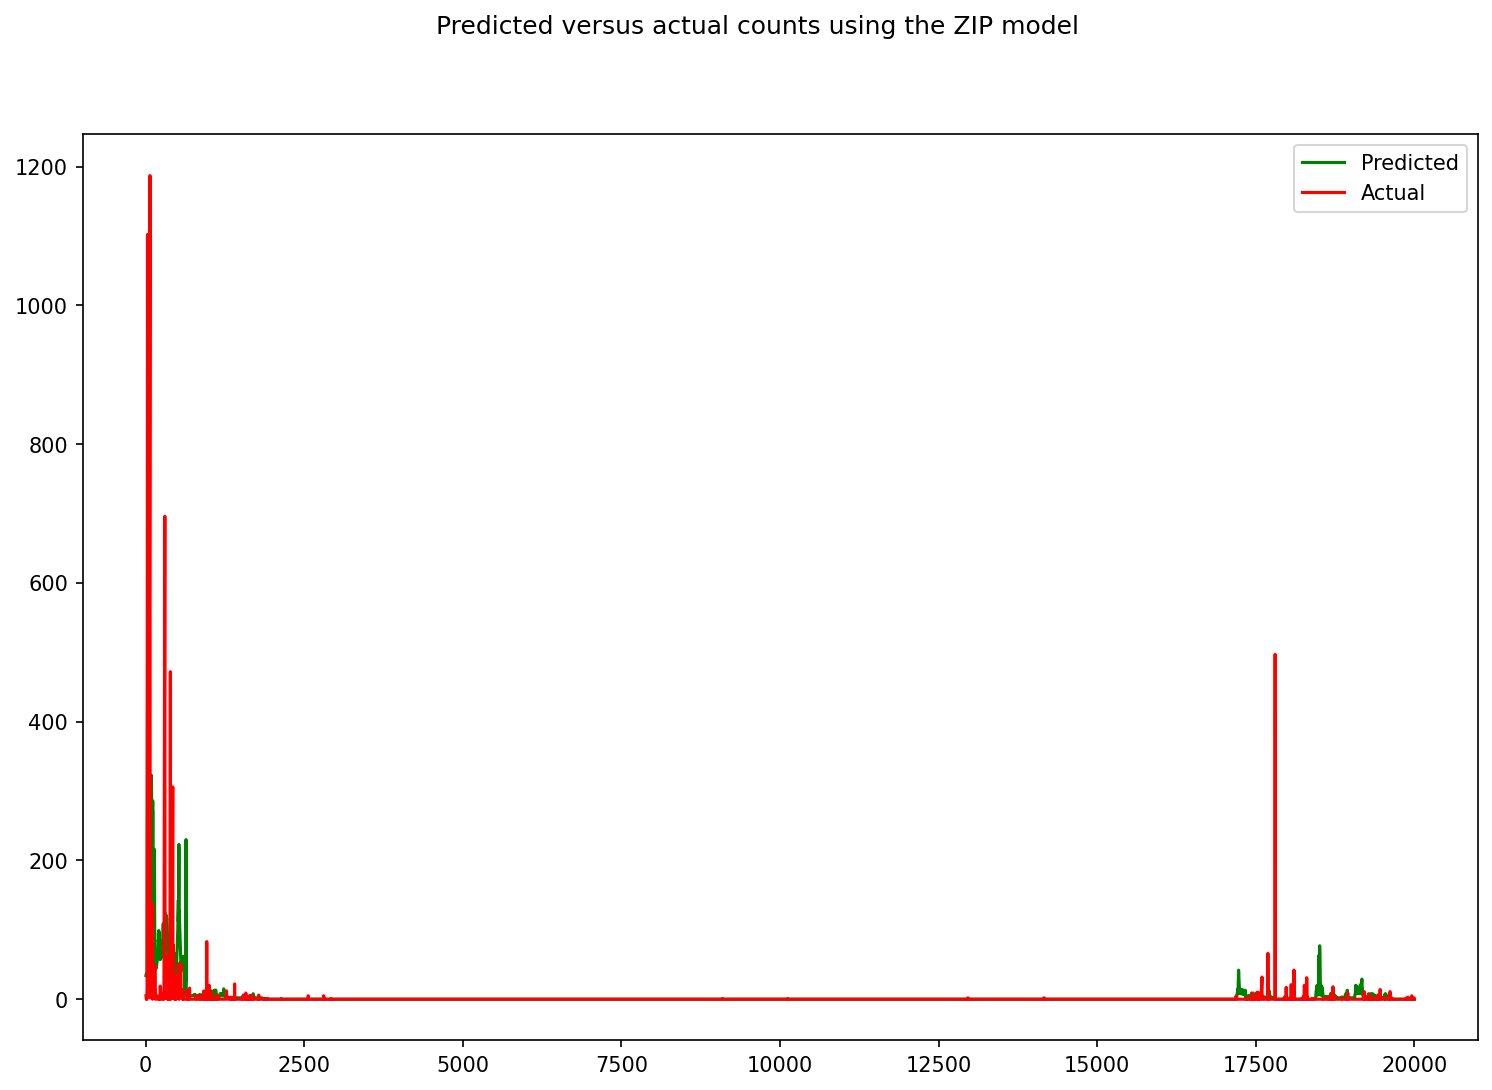

In [54]:
#zero inflated
from patsy import dmatrices


df = flujos_loc

expr = "personas_mig ~ cod_ori + log_dist -1"

mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))


y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()

zip_training_results.summary()

zip_predictions = zip_training_results.predict(X_test,exog_infl=X_test)

predicted_counts=np.round(zip_predictions)

actual_counts = y_test['personas_mig']

print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2)))))



fig = plt.figure(figsize=(12, 8), dpi=150)

fig.suptitle('Predicted versus actual counts using the ZIP model')

predicted, = plt.plot(X_test.index, predicted_counts, 'g', label='Predicted')

actual, = plt.plot(X_test.index, actual_counts, 'r', label='Actual')

plt.legend(handles=[predicted, actual])

plt.show()

In [1]:
prodSim.summary()

NameError: name 'prodSim' is not defined

In [3]:
# funciones para recuperar parámetros e imprimir
def get_gml_params(model, variables):
    "Accede a los parámetros alfa y beta dentro de los resutaldos del modelo"
    params = [model.params[i] for i in variables]
    params_str = [str(round(i, 4)) for i in params]
    return params, params_str

def print_params(variables, params_list):
    "Imprime los parámetros"
    return print("""alpha ({}) = {}\nbeta ({}) = {}
    """.format(variables[0], params_list[0], variables[1], params_list[1]))

In [4]:
# imprime parámetros
variables= ['cod_ori', 'log_dist']

params, params_str = get_gml_params(prodSim, variables)

print_params(variables, params_str)

NameError: name 'prodSim' is not defined

In [14]:
# crea la sumatoria de migrantes en origen (Oi)
O_i = flujos_loc.groupby('cod_ori')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'O_i'})

# crea la sumatoria de migrantes en destino (Di)
D_j = flujos_loc.groupby('cod_des')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'D_j'})

# pega ambas variables con el df
flujos_loc = flujos_loc.merge(O_i, left_on='cod_ori', right_index=True)
flujos_loc = flujos_loc.merge(D_j, left_on='cod_des', right_index=True)

flujos_loc.head()

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,log_dist,O_i,D_j
0,10202220,1020,2220,1304729,40657,635.000,583715,13.277168,55484.172,1043.544
1229,25212220,2521,2220,12200,40657,0.001,137927,11.834480,1172.518,1043.544
1843,25222220,2522,2220,2659,40657,0.001,111408,11.620954,144.595,1043.544
2457,26212220,2621,2220,2531,40657,0.001,106867,11.579340,191.580,1043.544
3071,27212220,2721,2220,380,40657,0.001,58392,10.974934,12.609,1043.544


In [17]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder pegar
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','', regex=True).values)),
            inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
flujos_loc = flujos_loc.merge(mu_i, left_on='cod_ori', right_index=True)

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [18]:
mu_i

,mu_i
cod_ori,-0.000149
log_dist,0.010713


In [16]:
flujos_loc

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,log_dist,O_i,D_j
0,10202220,1020,2220,1304729,40657,635.000,583715,13.277168,55484.172,1043.544
1229,25212220,2521,2220,12200,40657,0.001,137927,11.834480,1172.518,1043.544
1843,25222220,2522,2220,2659,40657,0.001,111408,11.620954,144.595,1043.544
2457,26212220,2621,2220,2531,40657,0.001,106867,11.579340,191.580,1043.544
3071,27212220,2721,2220,380,40657,0.001,58392,10.974934,12.609,1043.544
...,...,...,...,...,...,...,...,...,...,...
374540,199671020,19967,1020,41,1304729,0.001,373520,12.830727,0.614,40003.224
375154,199681020,19968,1020,55,1304729,0.001,327602,12.699555,0.614,40003.224
375768,199691020,19969,1020,72,1304729,0.001,386414,12.864665,0.614,40003.224
376382,199701020,19970,1020,25,1304729,0.001,316572,12.665306,0.614,40003.224


In [ ]:
# genera estimación redondeada
def prod_sim_est(df, variables, alpha, beta):
    "Estimación del modelo imputando los parámetros alfa y beta previamente calculados"
    prodsimest = np.exp(df['mu_i'] + alpha * df[variables[0]] + beta * df[variables[1]])
    return round(prodsimest)